In [1]:
import tensorflow as tf
import numpy as np
import sys
sys.path.append("/home/joosep/particleflow/mlpf")
import tfmodel.model
import tfmodel.data
import tfmodel.model_setup

import yaml
import matplotlib.pyplot as plt
import matplotlib 
import os
os.chdir("/home/joosep/particleflow")

import pandas
import networkx
import glob

from matplotlib import cm

In [2]:
with open("/home/joosep/particleflow/parameters/cms-gnn-dense-dev.yaml") as f:
    config = yaml.load(f)
config["setup"]["multi_output"] = True
config["parameters"]["debug"] = True

<ipython-input-2-30d2deb1d9c5>:2: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  config = yaml.load(f)


In [3]:
model = tfmodel.model_setup.make_gnn_dense(config, tf.float32)

In [4]:
cds = config["dataset"]

dataset_def = tfmodel.data.Dataset(
    num_input_features=int(cds["num_input_features"]),
    num_output_features=int(cds["num_output_features"]),
    padded_num_elem_size=6400,
    raw_path=cds.get("raw_path", None),
    raw_files=cds.get("raw_files", None),
    processed_path=cds["processed_path"],
    validation_file_path="data/TTbar_14TeV_TuneCUETP8M1_cfi/val/pfntuple_*.pkl.bz2",
    schema=cds["schema"]
)

dataset_transform = tfmodel.model_setup.targets_multi_output(config['dataset']['num_output_classes'])

raw files: 0
val files: 1998


In [9]:
Xs = []
ygens = []
ycands = []

for fi in dataset_def.val_filelist[:10]:
    print(fi)
    X, ygen, ycand = dataset_def.prepare_data(fi)

    Xs.append(np.concatenate(X))
    ygens.append(np.concatenate(ygen))
    ycands.append(np.concatenate(ycand))

X_val = np.concatenate(Xs)
ygen_val = np.concatenate(ygens)
ycand_val = np.concatenate(ycands)

X_val, ycand_val, _ = dataset_transform(X_val, ycand_val, None)


data/TTbar_14TeV_TuneCUETP8M1_cfi/val/pfntuple_8201_0.pkl.bz2
data/TTbar_14TeV_TuneCUETP8M1_cfi/val/pfntuple_8202_0.pkl.bz2
data/TTbar_14TeV_TuneCUETP8M1_cfi/val/pfntuple_8203_0.pkl.bz2
data/TTbar_14TeV_TuneCUETP8M1_cfi/val/pfntuple_8204_0.pkl.bz2
data/TTbar_14TeV_TuneCUETP8M1_cfi/val/pfntuple_8205_0.pkl.bz2
data/TTbar_14TeV_TuneCUETP8M1_cfi/val/pfntuple_8206_0.pkl.bz2
data/TTbar_14TeV_TuneCUETP8M1_cfi/val/pfntuple_8207_0.pkl.bz2
data/TTbar_14TeV_TuneCUETP8M1_cfi/val/pfntuple_8208_0.pkl.bz2
data/TTbar_14TeV_TuneCUETP8M1_cfi/val/pfntuple_8209_0.pkl.bz2
data/TTbar_14TeV_TuneCUETP8M1_cfi/val/pfntuple_820_0.pkl.bz2


In [85]:
vals_a = np.sin(X_val[:, :, 3].flatten())

In [86]:
vals_b = ycand_val["sin_phi"][:, :, 0].flatten()

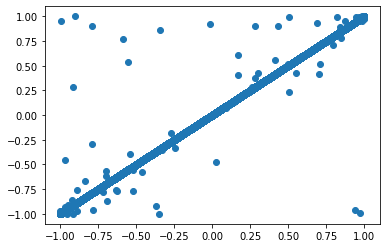

In [91]:
msk =np.argmax(ycand_val["cls"], axis=-1).flatten()==1
plt.scatter(vals_a[msk], vals_b[msk])

In [ ]:
ret = model(X_val[:1])
model.set_trainable_classification()
model.load_weights("/home/joosep/particleflow/experiments/cms-gnn-dense-a301aa09.gpu0.local/weights-65-103.547722.hdf5")
ret = model.predict(X_val, batch_size=10)

In [ ]:
x = X_val[0]
msk = x[:, 0] == 8

In [ ]:
preds = model(X_val[:1], training=False)

In [ ]:
def get_bin_index(bs):
    bin_index = []

    for ielem in range(6400):
        if X_val[0, ielem, 0] != 0:
            for ibin in range(bs.shape[1]):
                if ielem in bs[ibin]:
                    bin_index.append(ibin)
                    break
        else:
            break
    return bin_index

In [ ]:
msk = X_val[0][:, 0] != 0
eta = X_val[0][msk, 2]
phi = X_val[0][msk, 3]
typ = X_val[0][msk, 0]
energy = X_val[0][msk, 4]

evenly_spaced_interval = np.linspace(0, 1, 10)
colorlist = [cm.rainbow(x) for x in evenly_spaced_interval]
bin_idx = get_bin_index(preds["combined_graph_layer"]["bins"][0].numpy())

plt.figure(figsize=(4,4))
plt.scatter(eta, phi, c=[colorlist[bi] for bi in bin_idx], marker=".")
plt.xlabel("eta")
plt.ylabel("phi")
plt.title("Binning in classification layer 1")
plt.savefig("bins_cls_layer1.pdf")

In [ ]:
evenly_spaced_interval = np.linspace(0, 1, 10)
colorlist = [cm.rainbow(x) for x in evenly_spaced_interval]
bin_idx = get_bin_index(preds["combined_graph_layer_1"]["bins"][0].numpy())

plt.figure(figsize=(4,4))
plt.scatter(eta, phi, c=[colorlist[bi] for bi in bin_idx], marker=".")
plt.xlabel("eta")
plt.ylabel("phi")
plt.title("Binning in classification layer 2")
plt.savefig("bins_cls_layer2.pdf")

In [ ]:
bin_idx = get_bin_index(preds["combined_graph_layer_2"]["bins"][0].numpy())

plt.figure(figsize=(4,4))
plt.scatter(eta, phi, c=[colorlist[bi] for bi in bin_idx], marker=".")
plt.xlabel("eta")
plt.ylabel("phi")
plt.title("Binning in regression layer 1")
plt.savefig("bins_reg_layer1.pdf")

In [ ]:
bin_idx = get_bin_index(preds["combined_graph_layer_3"]["bins"][0].numpy())

plt.figure(figsize=(4,4))
plt.scatter(eta, phi, c=[colorlist[bi] for bi in bin_idx], marker=".")
plt.xlabel("eta")
plt.ylabel("phi")
plt.title("Binning in regression layer 1")
plt.savefig("bins_reg_layer2.pdf")

In [ ]:
def plot_dms(dms):
    fig = plt.figure(figsize=(4*4, 3*4))
    for i in range(dmn.shape[0]):
        ax = plt.subplot(3,4,i+1)
        plt.axes(ax)
        plt.imshow(dmn[i], interpolation="none", norm=matplotlib.colors.Normalize(vmin=0, vmax=1), cmap="Blues")
        plt.colorbar()
        plt.title("bin {}".format(i))
        #plt.xlabel("elem index $i$")
        #plt.ylabel("elem index $j$")
    plt.tight_layout()

In [ ]:
dmn = preds["combined_graph_layer"]["dm"][0].numpy()
plot_dms(dmn)
plt.suptitle("Learned adjacency, classification layer 1", y=1.01)
plt.savefig("dm_cls1.pdf")

In [ ]:
dmn = preds["combined_graph_layer_1"]["dm"][0].numpy()
plot_dms(dmn)
plt.suptitle("Learned adjacency, classification layer 2", y=1.01)
plt.savefig("dm_cls2.pdf")

In [ ]:
dmn = preds["combined_graph_layer_2"]["dm"][0].numpy()
plot_dms(dmn)
plt.suptitle("Learned adjacency, regression layer 1", y=1.01)
plt.savefig("dm_reg1.pdf")

In [ ]:
dmn = preds["combined_graph_layer_3"]["dm"][0].numpy()
plot_dms(dmn)
plt.suptitle("Learned adjacency, regression layer 2", y=1.01)
plt.savefig("dm_reg2.pdf")